In [2]:
import mne

In [3]:
import matplotlib.pyplot as plt

In [4]:
import json

In [5]:
import pandas as pd

In [6]:
import numpy as np

In [7]:
raw = mne.io.read_raw_eeglab("./data/sub-001_task-ContinuousVideoGamePlay_run-02_eeg.set", preload=True)

Reading ./data/sub-001_task-ContinuousVideoGamePlay_run-02_eeg.fdt
Reading 0 ... 1398674  =      0.000 ...  2797.348 secs...


<ipython-input-7-86088f157167>:1: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab("./data/sub-001_task-ContinuousVideoGamePlay_run-02_eeg.set", preload=True)


In [8]:
log_df = pd.read_csv("./data/Axon_GAME_Log_601_2015-01-21.15-47.csv")

In [9]:
events_df = pd.read_csv("./data/sub-001_task-ContinuousVideoGamePlay_run-02_events.tsv", sep="\t")

In [10]:
%matplotlib inline

# First hypothesis
How user engagement differs for shooting and receiving damage

Get event types

In [11]:
event_types_df = events_df.groupby(["value", "trial_type"]).size().reset_index()

In [12]:
event_types = event_types_df.set_index("value")["trial_type"].to_dict()

In [13]:
events, event_id = mne.events_from_annotations(raw)

Used Annotations descriptions: ['S 90', 'S 91', 'S 92', 'S 93', 'S 94', 'S 97', 'S 98', 'S 99', 'S100', 'S101', 'S102', 'S103', 'S104', 'boundary']


In [14]:
named_event_id = {event_types[k]: v for k, v in event_id.items()}

Extract epochs, from 0 to 3 seconds after stimulus

In [15]:
epochs = mne.Epochs(
    raw,
    events,
    event_id=named_event_id,
    tmin=0,
    tmax=3,
    baseline=None,
    preload=True
)

Not setting metadata
Not setting metadata
3896 matching events found
No baseline correction applied
0 projection items activated
Loading data for 3896 events and 1501 original time points ...
4 bad epochs dropped


In [16]:
epochs_part = epochs.copy().pick(["Fp1"])

Select events to compare

In [18]:
event_one = 'SHOOT_BUTTON'
event_two = 'PLAYER_CRASH_WALL'

In [19]:
data_one = epochs_part[event_one].get_data()
data_two = epochs_part[event_two].get_data()

In [20]:
frequencies_one = np.abs(np.fft.fft(data_one, 500, axis=-1))[:, :, 0:30]
frequencies_two = np.abs(np.fft.fft(data_two, 500, axis=-1))[:, :, 0:30]

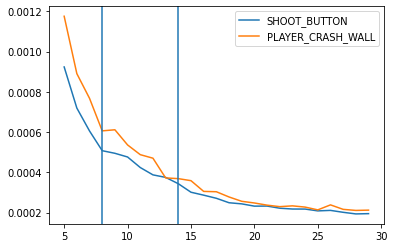

In [21]:
plt.plot(np.arange(5, 30), frequencies_one[:, :, 5:30].mean(axis=0).reshape(-1), label=event_one)
plt.plot(np.arange(5, 30), frequencies_two[:, :, 5:30].mean(axis=0).reshape(-1), label=event_two)
plt.axvline(8)
plt.axvline(14)
plt.legend()
# plt.xlim(5, 30)
# plt.ylim(-9, -6)

In [25]:
# Extraction of the selected frequencies, 8-12Hz
sample_one = frequencies_one[:, :, 8:12].sum(axis=-1).reshape(-1)
sample_two = frequencies_two[:, :, 8:12].sum(axis=-1).reshape(-1)

In [26]:
bins=np.linspace(np.quantile(sample_two, 0.01), np.quantile(sample_two, 0.99), 20)

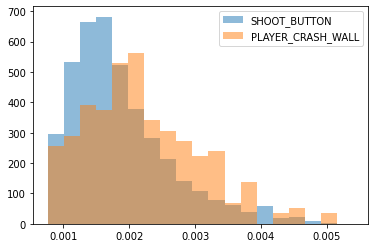

In [27]:
plt.hist(sample_one, bins=bins, density=True, alpha=0.5, label=event_one)
plt.hist(sample_two, bins=bins, density=True, alpha=0.5, label=event_two)
plt.legend()

In [28]:
from scipy import stats

In [29]:
sample_one.mean(), sample_two.mean()

(0.0019023028775046072, 0.0022413572888160885)

In [30]:
stats.mannwhitneyu(sample_one, sample_two)

MannwhitneyuResult(statistic=129484.0, pvalue=8.657524687195375e-10)

In [31]:
stats.ttest_ind(sample_one, sample_two)

Ttest_indResult(statistic=-3.423863896786633, pvalue=0.0006327169254471916)

# Second hypothesis
How number of enemies on a screen affects engagement

Merge event log and annotations

In [32]:
event_seconds_log_1 = np.array([d['onset'] for d in list(raw.annotations) if d["description"] == 'S 94'])

In [33]:
(event_seconds_log_1[1:] - event_seconds_log_1[:-1])[0:10]

array([34.78 ,  6.788, 54.48 , 34.828, 32.32 , 21.94 ,  7.758, 52.318,
       11.608, 31.772])

In [34]:
event_seconds_log_2 = log_df[log_df[" Ammo"].shift() < log_df[" Ammo"]]["Seconds"].values

In [35]:
(event_seconds_log_2[1:] - event_seconds_log_2[:-1])[0:10]

array([34.7785,  6.7873, 54.4793, 34.828 , 32.3205, 21.9394,  7.7572,
       52.3173, 11.6084, 31.7706])

In [36]:
event_log_difference = event_seconds_log_1[0] - event_seconds_log_2[0]

Test hypothesis about the game state

In [37]:
star_columns = [c for c in log_df.columns if 'Enemy' in c and 'Angle' in c]

In [38]:
stars_df = (log_df[star_columns] != 0).sum(axis=1).to_frame().copy()

In [39]:
stars_df["Seconds"] = log_df["Seconds"]

In [40]:
stars_df = stars_df.iloc[1:]

In [41]:
all_events = np.array([d['onset'] for d in list(raw.annotations)])

In [42]:
all_events_eeg_timestamps = all_events

In [43]:
from tqdm import tqdm_notebook

In [44]:
stars_df["event"] = -1

for i, timestamp in enumerate(tqdm_notebook(all_events_eeg_timestamps)):
    stars_df.loc[(stars_df["Seconds"] >= timestamp - event_log_difference - 0.1) & (stars_df["Seconds"] <= timestamp - event_log_difference + 0.1), "event"] = int(timestamp * 500)

/home/anatoli/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [45]:
stars_by_event = stars_df.groupby("event")[0].mean().astype(int).iloc[1:].reset_index()

In [56]:
events_indices = {v: i for i, v in enumerate(epochs.events.T[0])}

In [57]:
epochs_by_stars = {}

In [58]:
for i, group_df in stars_by_event.groupby(0)["event"]:
    i = {
        0: 1,
        1: 1,
        2: 1,
        3: 3,
        4: 4,
        5: 4
    }[i]
    if i not in epochs_by_stars:
        epochs_by_stars[i] = []
    
    for row in group_df:
        if row not in events_indices:
            print("Problem with", row)
            break
        epochs_by_stars[i].append(epochs_part[events_indices[row]])

Problem with 48782
Problem with 102491
Problem with 105612
Problem with 515799
Problem with 833744


Check hypothesis for each group

In [59]:
for i in sorted(epochs_by_stars.keys()):
    print(i, len(epochs_by_stars[i]))

1 120
3 55
4 26


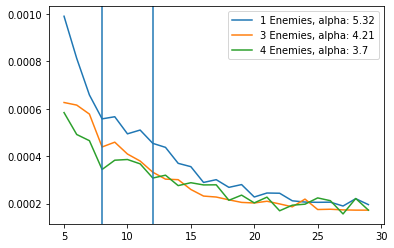

In [60]:
for i in sorted(epochs_by_stars.keys()):
    epochs_group = epochs_by_stars[i]
    epochs_data = np.vstack([e.get_data().reshape(-1) for e in epochs_group])
    epochs_frequencies = np.abs(np.fft.fft(epochs_data, 500, axis=-1))[:, 0:30]
    avg_value = round(epochs_frequencies[:, 8:12].mean(axis=0).mean() * 10000, 2)
    plt.plot(np.arange(5, 30), epochs_frequencies[:, 5:30].mean(axis=0).reshape(-1), label=f"{i} Enemies, alpha: {avg_value}")
    
plt.axvline(8)
plt.axvline(12)
plt.legend()